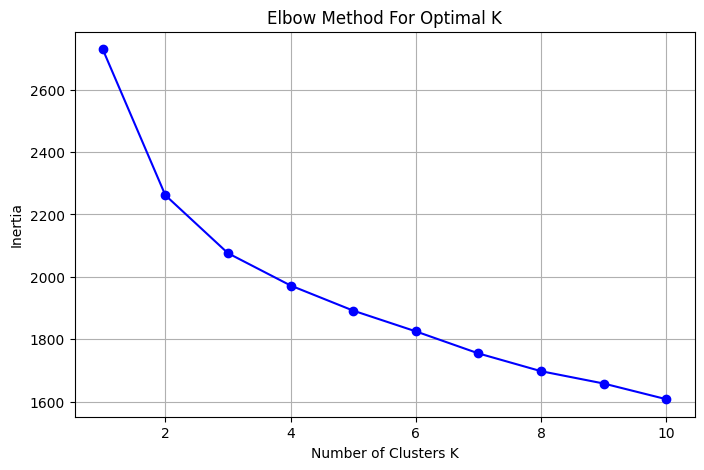

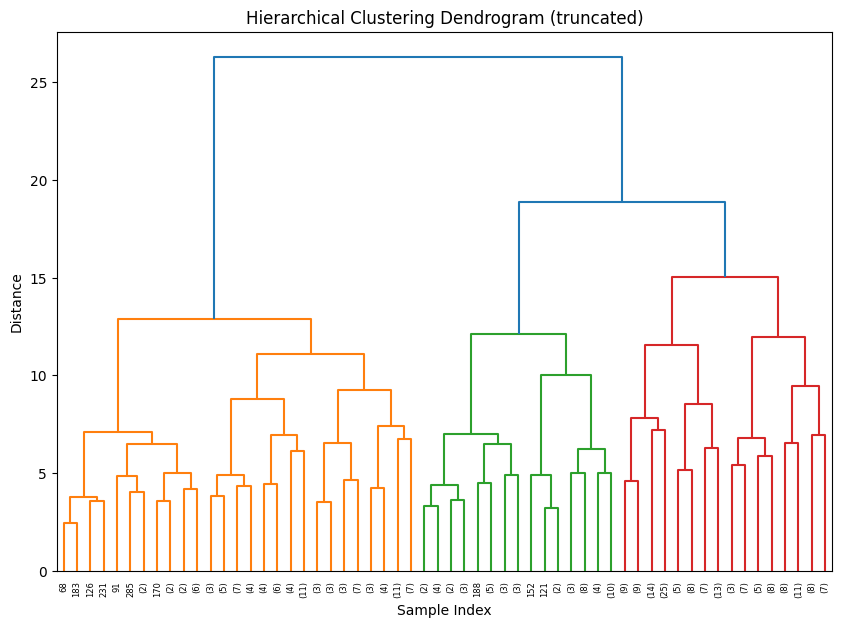

Adjusted Rand Index (KMeans): 0.1900
Adjusted Rand Index (Hierarchical): 0.2095


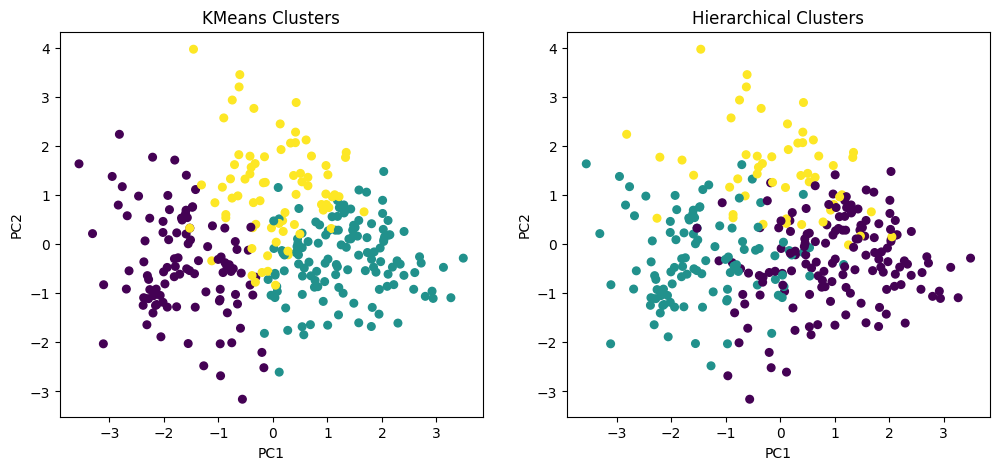

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

# 1. Load cleaned data and columns
df = pd.read_csv('../data/heart_disease_clean.csv')
with open('../models/cols.json', 'r') as f:
    cols = json.load(f)
num_cols = cols['num_cols']
cat_cols = cols['cat_cols']

# 2. Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# 3. Preprocess features (same pipeline as before)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])
X_processed = preprocessor.fit_transform(X)

# 4. Elbow method to find optimal K for KMeans
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.grid(True)
plt.show()

# Choose K (example: 3)
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_processed)

# 5. Hierarchical clustering & dendrogram
linked = linkage(X_processed, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Cut dendrogram to get clusters (same K)
hier_clust = AgglomerativeClustering(n_clusters=k_optimal)
clusters_hier = hier_clust.fit_predict(X_processed)

# 6. Compare clusters with true labels (Adjusted Rand Index)
ari_kmeans = adjusted_rand_score(y, clusters_kmeans)
ari_hier = adjusted_rand_score(y, clusters_hier)

print(f"Adjusted Rand Index (KMeans): {ari_kmeans:.4f}")
print(f"Adjusted Rand Index (Hierarchical): {ari_hier:.4f}")

# 7. Visualize cluster assignments (using PCA 2D projection)
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_processed)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters_kmeans, cmap='viridis', s=30)
plt.title('KMeans Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 2, 2)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters_hier, cmap='viridis', s=30)
plt.title('Hierarchical Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()
